$$
\LaTeX macros
\newcommand{\pba}{{p^b_a}}
\newcommand{\de}{{\dot{e}}}
\newcommand{\dde}{{\ddot{e}}}
\newcommand{\pbd}{{p^b_d}}
\newcommand{\dpba}{{\dot{p}^b_a}}
\newcommand{\ddpba}{{\ddot{p}^b_a}}
\newcommand{\dpbd}{{\dot{p}^b_d}}
\newcommand{\ddpbd}{{\ddot{p}^b_d}}
\newcommand{\pag}{{p^a_g}}
\newcommand{\pav}{{p^a_v}}
\newcommand{\dpag}{{\dot{p}^a_g}}
\newcommand{\pai}{{p^a_i}}
\newcommand{\dpai}{{\dot{p}^a_i}}
\newcommand{\pbg}{{p^b_g}}
\newcommand{\dpbg}{{\dot{p}^b_g}}
\newcommand{\ddpbg}{{\ddot{p}^b_g}}
\newcommand{\pbi}{{p^b_i}}
\newcommand{\dpbi}{{\dot{p}^b_i}}
\newcommand{\ddpbi}{{\ddot{p}^b_i}}
\newcommand{\Rba}{{R^b_a}}
\newcommand{\dRba}{{\dot{R}{}^b_a}}
\newcommand{\ddRba}{{\ddot{R}{}^b_a}}
\newcommand{\Rab}{{R^a_b}}
\newcommand{\omaa}{{\omega^a_a}}
\newcommand{\domaa}{{\dot{\omega}{}^a_a}}
\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}
\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}
\newcommand{\Spag}{{S\left(p^a_g\right)}}
\newcommand{\Spai}{{S\left(p^a_i\right)}}
\newcommand{\nuaa}{{\nu^a_a}}
\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}
\newcommand{\Fb}{{F^b}}
\newcommand{\Fa}{{F^a}}
\newcommand{\Fg}{{F_g}}
\newcommand{\Fv}{{F_v}}
\newcommand{\Ng}{{N_g}}
\newcommand{\Nv}{{N_v}}
\newcommand{\Fe}{{F^{ext}}}
\newcommand{\Na}{{N^a}}
\newcommand{\iM}{{M^{-1}}}
\newcommand{\BM}{\left[\begin{matrix}}
\newcommand{\EBM}{\end{matrix}\right]}
\newcommand{\gamaa}{{\gamma^a_a}}
\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vt}{\vec{\tau}}
\newcommand{\vn}{\vec{\nu}}
\newcommand{\T}{^\top}
\newcommand{\o}[1]{{\overline{#1}}}
\newcommand{\d}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\xpba}{{\,}^x{\!}p^b_a}
\newcommand{\ypba}{{\,}^y{\!}p^b_a}
\newcommand{\As}{{A^{\!*}}}
$$


## Implementacja artykułu "Adaptive sliding-mode attitude control for autonomous underwater vehicles with input nonlinearities"

Link do artykułu:    https://doi.org/10.1016/j.oceaneng.2016.06.041

## Import

In [1]:
import sympy as sp 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt # ploting results
from scipy.integrate import solve_ivp # solving differential equations
from scipy import linalg # solving are
MAT = np.array
%config IPCompleter.greedy=True

In [2]:
#definicja dekoratora log_results
import functools

def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec

## Zmienne symboliczne

In [3]:
t = sp.symbols('t') # czas
psi_, tta_, phi_ = sp.symbols('\\psi \\theta \\phi', cls=sp.Function)# kąty Eulera kolejno yaw, pitch, roll
psi, tta, phi = psi_(t), tta_(t), phi_(t)
psi_0, Omy_0 = sp.symbols('\\psi(0) \\omega_y(0)')
x_, y_, z_ = sp.symbols('x y z', cls=sp.Function) # położenie torpedy w układzie globalnym
x, y, z = x_(t), y_(t), z_(t)
Vx_, Vy_, Vz_ = sp.symbols('V_x V_y V_z', cls=sp.Function) # prędkosci liniowe w układzie lokalnym
Vx, Vy, Vz = Vx_(t), Vy_(t), Vz_(t)
dVx_, dVy_, dVz_ = sp.symbols('\dot{V}_x \dot{V}_y \dot{V}_z', cls=sp.Function) # prędkosci liniowe w układzie lokalnym
dVx, dVy, dVz = dVx_(t), dVy_(t), dVz_(t)
Omx_, Omy_, Omz_ = sp.symbols('\\omega_x \\omega_y \\omega_z', cls=sp.Function) # prędkosci kątowe w układzie lokalnym
Omx, Omy, Omz = Omx_(t), Omy_(t), Omz_(t)
dOmx_, dOmy_, dOmz_ = sp.symbols('\dot{\\omega}_x \dot{\\omega}_y \dot{\\omega}_z', cls=sp.Function) # prędkosci kątowe w układzie lokalnym
dOmx, dOmy, dOmz = dOmx_(t), dOmy_(t), dOmz_(t)
V = sp.symbols('V') # prędkość wypadkowa sqrt(Vx^2 + Vy^2 + Vz^2)
xc, yc, zc = sp.symbols('x_c y_c z_c') # współrzędne odległości od środka ciężkości do środka wyporności 
de, dr, dd = sp.symbols('\\delta_e \\delta_r \\delta_d')

beta, alpha = sp.symbols('\\beta \\alpha') # kąt pooślizgu i natarcia
m, rho, L, S, T = sp.symbols('m \\rho L S T') # masa torpedy, gęstość wody, długość i przekrój poprzeczny torpedy, siła ciagu
lam11, lam22, lam33, lam44 = sp.symbols('\\lambda_{11} \\lambda_{22} \\lambda_{33} \\lambda_{44}') # masa dodana
lam26, lam35, lam55, lam66 = sp.symbols('\\lambda_{26} \\lambda_{35} \\lambda_{55} \\lambda_{66}') # masa dodana
Jxx, Jyy, Jzz = sp.symbols('J_{xx} J_{yy} J_{zz}') # dodany moment bezwładności
G, dG, dMxp = sp.symbols('G {\\Delta}G {\\Delta}M_{xp}') # współczynniki
Ca_xs, Ca_y, Cde_y, Cwz_y, Cb_z, Cdr_z, Cwy_z = sp.symbols('C^{\\alpha}_{xS} C^{\\alpha}_{y} C^{\\delta_e}_{y} C^{\\omega_z}_{y} C^{\\beta}_{z} C^{\\delta_r}_{z} C^{\\omega_y}_{z}')
mb_x, mdr_x, mdd_x, mox_x, moy_y, mb_y = sp.symbols('m^{\\beta}_x m^{\\delta_r}_x m^{\\delta_d}_x m^{\\omega_x}_x m^{\\omega_y}_y m^{\\beta}_y ')
mdr_y, mox_y, ma_z, mde_z, moz_z = sp.symbols('m^{\\delta_r}_y m^{\\omega_x}_y m^{\\alpha}_z m^{\\delta_e}_z m^{\\omega_z}_z')
c1, c2, c3 = sp.symbols('c_1 c_2 c_3') # c1 c2 wspł hydrodynamiczne c3 wspł wzm sterowania petli otwartej 
c4, c5, c6 = sp.symbols('c_4 c_5 c_6')
f_, d_ = sp.symbols('f d', cls=sp.Function)
f, d = f_(V,psi,Omy,t), d_(t)
D, h, PHI = sp.symbols('D h \\Phi') # nieliniowa część dynamiki i zaburzenia
s, e, edot, lam = sp.symbols('s e \dot{e} \\lambda') # zmienne sterownika ślizgowego
bhat, hhat, rhohat, Lest, tau, k = sp.symbols('\hat{b} \hat{h} \hat{\\rho} L_{est} \\tau k')#estymaty i wzmocnienia
PSId, PSIdbis, PSIddot = sp.symbols('\\Psi_d \ddot{\\Psi}_d \dot{\\Psi}_d') #wartości kąta zadanego, 2 pochoodna, 1 pochodna
k1, k2, k3 = sp.symbols('k_1 k_2 k_3')# wzmocnienia pochodnych estymat
Phib = sp.symbols('\\Phi_b') #wsp ograniczenia funkcji saturacji 
sig, mu, u = sp.symbols('\\sigma m_u u') #zmienne sterowania z martwą strefą
mr, ml, br, bl = sp.symbols('m_r m_l b_r b_l') #parametry martwej strefy
Omyhat, Omyhatdot, k06, k07 = sp.symbols('\hat{\\omega}_y \dot{\hat{\\omega}}_y k_{06} k_{07}')
Dhat, mihat, ghat = sp.symbols('\hat{D} \hat{\\mu} \hat{g}')
b1hat, L1est = sp.symbols('\hat{b}_1 L_{1est}')
k01, k02, k03, k04, k05 = sp.symbols('k_{01} k_{02} k_{03} k_{04} k_{05}')#wsp wzm prawa adaptacji 
drm = sp.symbols('\\delta_{rm}')#górny poziom nasycenia
kwindup, l, c3b, w, du = sp.symbols('k^* l \\bar{c}_3 w {\\Delta}u')
b2, L2est, c3h = sp.symbols('\hat{b}_2 L_{2est} \\hat{c}_3')
c1h, c2h, c3h = sp.symbols('\hat{c}_1 \hat{c}_2 \hat{c}_3')
c1h_0, c2h_0, c3h_0, rhoh_0, bh_0, gh_0, mih_0, Omyh_0, Dh_0 = sp.symbols('\\hat{c}_1(0) \\hat{c}_2(0) \\hat{c}_3(0) \\hat{\\rho}(0) \\hat{b}(0) \\hat{g}(0) \\hat{\\mu}(0) \\hat{\\omega}_y(0) \\hat{D}(0)')

Definicja kąta poślizgu $\beta$ i kąta natarcia $\alpha$ - rozdział 2.1 opis przed wzorem (1)

In [4]:
beta_ = sp.atan(Vz/sp.sqrt(Vx**2+Vy**2))
alpha_ = -sp.atan(Vy/Vx)

vxtmp, vytmp, vztmp = sp.symbols('vxt vyt vzt') 
beta_slim = beta_.subs(Vz, vztmp)
beta_slim = beta_slim.subs(Vx, vxtmp)
beta_slim = beta_slim.subs(Vy, vytmp)
display(beta_slim)
beta_f = sp.lambdify([vxtmp, vytmp, vztmp], beta_slim)

alpha_slim = alpha_.subs(Vx, vxtmp)
alpha_slim = alpha_slim.subs(Vy, vytmp)
display(alpha_slim)
alpha_f = sp.lambdify([vxtmp, vytmp], alpha_slim)

podstaw = {beta:0.05,alpha:alpha_}
display(beta_,alpha_)

atan(vzt/sqrt(vxt**2 + vyt**2))

-atan(vyt/vxt)

atan(V_z(t)/sqrt(V_x(t)**2 + V_y(t)**2))

-atan(V_y(t)/V_x(t))

Opis kinematyki AUV - rozdział 2.1 (1)  $\BM \dot{x}\\\dot{y}\\\dot{z} \EBM$

In [5]:
Rot_ = sp.Matrix([[sp.cos(tta)*sp.cos(psi),sp.sin(psi)*sp.sin(phi)-sp.sin(tta)*sp.cos(psi)*sp.cos(phi),sp.sin(psi)*sp.cos(phi)+sp.sin(tta)*sp.cos(psi)],
                 [sp.sin(phi),sp.cos(tta)*sp.cos(phi),sp.sin(phi)-sp.cos(tta)*sp.sin(phi)],
                 [-sp.cos(tta)*sp.sin(psi),sp.cos(psi)*sp.sin(phi)+sp.sin(tta)*sp.sin(psi)*sp.cos(phi),sp.cos(psi)*sp.cos(phi)-sp.sin(tta)*sp.sin(psi)*sp.sin(phi)]])
V_ = sp.Matrix([[Vx, Vy, Vz]]).T
velState_ = Rot_@V_ # wektor stanu pochodnych położenia

stta, sphi, spsi = sp.symbols('stta spsi sphi')

slim = Rot_.subs(tta, stta)
slim = slim.subs(psi, spsi)
slim = slim.subs(phi, sphi)
display(Rot_,V_)

display(slim)
R_f = sp.lambdify([spsi, stta, sphi], slim)
print(R_f)
print(R_f(1,1,1))


Matrix([
[ cos(\psi(t))*cos(\theta(t)), sin(\phi(t))*sin(\psi(t)) - sin(\theta(t))*cos(\phi(t))*cos(\psi(t)),               sin(\psi(t))*cos(\phi(t)) + sin(\theta(t))*cos(\psi(t))],
[                sin(\phi(t)),                                          cos(\phi(t))*cos(\theta(t)),                           -sin(\phi(t))*cos(\theta(t)) + sin(\phi(t))],
[-sin(\psi(t))*cos(\theta(t)), sin(\phi(t))*cos(\psi(t)) + sin(\psi(t))*sin(\theta(t))*cos(\phi(t)), -sin(\phi(t))*sin(\psi(t))*sin(\theta(t)) + cos(\phi(t))*cos(\psi(t))]])

Matrix([
[V_x(t)],
[V_y(t)],
[V_z(t)]])

Matrix([
[ cos(sphi)*cos(stta), sin(sphi)*sin(spsi) - sin(stta)*cos(sphi)*cos(spsi),            sin(sphi)*cos(spsi) + sin(stta)*cos(sphi)],
[           sin(spsi),                                 cos(spsi)*cos(stta),                     -sin(spsi)*cos(stta) + sin(spsi)],
[-sin(sphi)*cos(stta), sin(sphi)*sin(stta)*cos(spsi) + sin(spsi)*cos(sphi), -sin(sphi)*sin(spsi)*sin(stta) + cos(sphi)*cos(spsi)]])

<function _lambdifygenerated at 0x00000132801E99D8>
[[ 0.29192658  0.46242567  0.90929743]
 [ 0.84147098  0.29192658  0.38682227]
 [-0.45464871  0.83722241 -0.30389665]]


Opis kinematyki AUV - rozdział 2.1 (2)  $\BM \dot{\psi}\\\dot{\theta}\\\dot{\phi} \EBM$

In [6]:
Rot2_ = sp.Matrix([[0,sp.sec(tta)*sp.cos(phi),sp.sec(tta)*sp.sin(phi)],
                   [0,sp.sin(phi),sp.cos(phi)],
                   [1,-sp.tan(tta)*sp.cos(phi),sp.tan(tta)*sp.sin(phi)]])
Om_ = sp.Matrix([[Omx,Omy,Omz]]).T
dAngState_ = Rot2_@Om_
#display(Rot2_,Om_)

Równania dynamiki - rozdział 2.1 (3)

In [7]:
dVx_ = (T-0.5*Ca_xs*rho*V**2*S-dG*sp.sin(tta))/(m + lam11)
dVy_ = (-(m*xc+lam26)*dOmz-m*Vx*Omz+0.5*rho*V**2*S*(Ca_y*alpha+Cde_y*de+Cwz_y*Omz)-dG*sp.cos(tta)*sp.cos(phi))/(m + lam22)
dVz_ = ((m*xc-lam35)*dOmy+m*Vx*Omy+0.5*rho*V**2*S*(Cb_z*beta+Cdr_z+Cwy_z)+dG*sp.cos(tta)*sp.sin(phi))/(m + lam22)
dOmx_ = (m*Vx*(yc*Omx+zc*Omx)+0.5*rho*V**2*S*L*(mb_x*beta+mdr_x*dr+mdd_x*dd+mox_x*Omx+moy_y*Omy)+G*sp.cos(tta)*(yc*sp.sin(phi)+zc*sp.cos(phi))+dMxp)/(Jxx+lam44)
dOmy_ = (-m*Vx*xc*Omy+(m*xc-lam35)*dVz+0.5*rho*V**2*S*L*(mb_y*beta+mdr_y*dr+mox_y*Omx+moy_y*Omy)-G*(xc*sp.cos(tta)*sp.sin(phi)+zc*sp.sin(tta)))/(Jyy+lam55)
dOmz_ = (-m*Vx*xc*Omz-(m*xc+lam26)*dVy+0.5*rho*V**2*S*L*(ma_z*alpha+mde_z*de+moz_z*Omz)+G*(yc*sp.sin(tta)-xc*sp.cos(tta)*sp.cos(phi)))/(Jzz+lam66)
#display(dVx_,dVy_,dVz_,dOmx_,dOmy_,dOmz_)

Obliczenie prędkości - rozdział 2.1 

In [8]:
V_ = sp.sqrt(Vx**2+Vy**2+Vz**2)
podstaw.update({V:V_})
#display(V_)

Równania dynamiki i kinematyki kąta odchylenia - rozdział 2.2 (4)

In [9]:
dPsi_ = Omy
dOmy_ = c1*Omy + c2*beta + c3*dr + f + d 
#display(dPsi_, dOmy_)

Kompaktowa forma wzoru (4) - rozdział 2.2 (5)

In [10]:
h_ = sp.Matrix([[c1,c2]]).T
PHI_ = sp.Matrix([[Omy,beta]]).T
dOmy2_ = sp.Transpose(h_)@PHI_ + sp.Matrix([[c3*dr]]) + sp.Matrix([[D]])
display(dOmy2_)

Matrix([[D + \beta*c_2 + \delta_r*c_3 + c_1*\omega_y(t)]])

Definicja błędwów śledzenia trajektorii zadanej - rozdział 2.2 (6)

In [11]:
e_ = psi - PSId
edot_ = Omy - PSIddot
podstaw.update({e:e_,edot:edot_})
display(e,edot_)

e

-\dot{\Psi}_d + \omega_y(t)

Sterowanie ślizgowe - rozdział 3 (7)

In [12]:
s_ = edot + lam*e
display(s_)

\dot{e} + \lambda*e

Prawo sterowania - rozdział 3 (13)

In [13]:
znak = sp.sign(s) 
Lest_ = -tau*s - k*znak - hhat*PHI - rhohat*znak + PSIdbis - lam*(Omy - PSIddot)
dr_ = bhat*Lest
podstaw.update({Lest:Lest_})
#display(dr_,Lest_)

Prawo adaptacji - rozdział 3 (14)

In [14]:
h1hatdot_ = k1*Omy*s
h2hatdot_ = k1*beta*s
hhatdot_ = sp.Matrix([[h1hatdot_,h2hatdot_]]).T
bhatdot_ = - k2*Lest*s
rhohatdot_ = k3*sp.Abs(s)
#display(hhatdot_,bhatdot_,rhohatdot_)

Saturacja sygnału - rozdział 3 (19)

In [15]:
def sat(sf_):
    if (sf_ > Phib): return 1
    elif (sf_ < -Phib): return -1
    else: return 1/Phib

Model sterowania z martwą strefą - sygnał sterujący - rozdział 4.1 (20)

In [16]:
dr2_ = mu*u + sig
display(dr2_)

\sigma + m_u*u

In [17]:
mr=0.3
ml=0.12
br=1
bl=1.3
def mu(u_):
    if(u_>0): return mr
    if(u_<=0): return ml
def sig(u_):
    if(u_<=-bl): return -ml*bl
    if(u_>-bl and  u_<=br): return mu(u_)*u_
    if(u_>=br): return mr*br

Obserwator zaburzeń - rozdział 4.2 (26)

In [18]:
Dhatdot_ = -k06*(Omyhat-Omy)
Omyhatdot_ = Dhat + mihat*u +ghat + c1h*Omy + c2h*beta - k07*(Omyhat - Omy)
display(Dhatdot_,Omyhatdot_)

-k_{06}*(\hat{\omega}_y - \omega_y(t))

\beta*\hat{c}_2 + \hat{D} + \hat{\mu}*u + \hat{c}_1*\omega_y(t) + \hat{g} - k_{07}*(\hat{\omega}_y - \omega_y(t))

Projekt sterownika dla wejścia z martwą strefą - rozdział 4.3 (27)

In [19]:
u_ = b1hat*L1est
hp = hhat*PHI
L1est1_ = -tau*s - k*sp.sign(s) - hp - ghat - Dhat - rhohat*sp.sign(s) + PSIdbis - lam*(Omy - PSIddot)
hp = c1h*Omy + c2h*beta
L1est_ = -tau*s - k*sp.sign(s) - hp - ghat - Dhat - rhohat*sp.sign(s) + PSIdbis - lam*(Omy - PSIddot)
podstaw.update({u:u_,L1est:L1est_})
display(u_,L1est1_)

L_{1est}*\hat{b}_1

-\Phi*\hat{h} + \ddot{\Psi}_d - \hat{D} - \hat{\rho}*sign(s) - \hat{g} - \lambda*(-\dot{\Psi}_d + \omega_y(t)) - \tau*s - k*sign(s)

Prawo adaptacji - rozdział 4.3 (30)

In [20]:
h12hatdot_ = k01*Omy*s - k01*(Omyhat-Omy)*Omy
h22hatdot_ = k01*beta*s - k01*(Omyhat-Omy)*beta
h1hatdot_ = sp.Matrix([[h12hatdot_,h22hatdot_]]).T
b1hatdot_ = -k02*L1est*s
rho1hatdot_ = k03*sp.Abs(s)
ghatdot_ = k04*s - k04*(Omyhat-Omy)
midothat_ = -k05*(Omyhat-Omy)*u
display(h1hatdot_,b1hatdot_,rho1hatdot_,ghatdot_,midothat_)

Matrix([
[k_{01}*s*\omega_y(t) - k_{01}*(\hat{\omega}_y - \omega_y(t))*\omega_y(t)],
[            \beta*k_{01}*s - \beta*k_{01}*(\hat{\omega}_y - \omega_y(t))]])

-L_{1est}*k_{02}*s

k_{03}*Abs(s)

k_{04}*s - k_{04}*(\hat{\omega}_y - \omega_y(t))

-k_{05}*u*(\hat{\omega}_y - \omega_y(t))

Sterowanie z nasyceniem - rozdział 4.4 
Charakterystyka saturacji (35)

In [21]:
drm = 12*np.pi/180
def drsat(u_):
    if(u_>drm): return drm
    if(u_<=drm and u_>=-drm): return u_
    if(u_<-drm): return -drm

Kompensator anti-windup - rozdział 4.4 (36)

In [22]:
du_ = dr-u
w_ = -kwindup*w - w*(sp.Abs(c3b*s*du)+0.5*du**2)/(sp.Abs(w)**2)+du 
podstaw.update({du:du_,w:w_})
#display(w_)

Prawo sterowania - rozdział 4.4 (37)

In [23]:
u2_ = b2*L2est
b2_ = 1/c3
L2est_ = -tau*(s - w) - k*sp.sign(s) - hhat*PHI - ghat - Dhat - rhohat*znak + PSIdbis - lam*(Omy - PSIddot)
podstaw.update({b2:b2_,L2est:L2est_})
#display(u2_,L2est_)

Obserwator zakłóceń - rozdział 4.4 (38)

In [24]:
D2hatdot_ = -k06*(Omyhat-Omy)
Omy2hatdot_ = Dhat + c3h*dr + hhat*PHI - k07*(Omyhat - Omy)
#display(D2hatdot_,Omy2hatdot_)

Prawo adaptacji - rozdział 4.4 (39)

In [25]:
h31hatdot_ = k01*Omy*s - k01*Omy*(Omyhat - Omy)
h32hatdot_ = k01*beta*s - k01*beta*(Omyhat - Omy)
h3_ = sp.Matrix([[h31hatdot_,h32hatdot_]]).T
b2dothat_ = -k02*L2est*s
rho2hatdot_ = k03*sp.Abs(s)
c3hatdot_ = -(Omyhat - Omy)*dr
#display(h3_,b2dothat_,rho2hatdot_,c3hatdot_)

Zewnętrzne zaburzenie - rozdział 5

In [26]:
dis_ = 0.55*sp.sin(0.01*t) + 0.33*sp.sin(0.1*t) + 0.25*sp.cos(0.02*t) + 0.3*sp.sin(0.1*t)*sp.cos(0.2*t)
dis_f = sp.lambdify([t], dis_)
#display(dis_)

Wymuszenie - rozdział 5

In [27]:
Trec = 50 #okres sygnału prostokątnego
Amp = 28.7 #amplituda sygnału prostokątnego
def Rectangle(t_):
    tmp = t_%Trec
    if(tmp<0.5*Trec): return 0
    if(tmp>=0.5*Trec): return Amp

## Wartości zmiennych symbolicznych

In [28]:
params ={c1:-4.695,c2:10.735,c3:1.8207,c4:0.2623,c5:-1.274,c6:-0.102}#nominalne parametry modelu
params.update({psi_0:10*np.pi/180,Omy_0:3*np.pi/180})#wartości początkowe
params.update({c1h_0:-1, c2h_0:2, c3h_0:0, rhoh_0:0.5, bh_0:0, gh_0:0, mih_0:0, Omyh_0:0, Dh_0:0.6})#wart. pocz. estymat
params.update({mr:0.3, ml:0.12, br:1, bl:1.3})#wart. saturacji i martwej strefy
params.update({k1:60, k2:60, k3:60, k01:60, k02:60, k03:60, k04:60, k05:60, k06:1, k07:1})#wzmocnienie poch. estymat
params.update({k:0.02, kwindup:20,tau:20,lam:1})
params.update({drm:12*np.pi/180})

Funkcje numeryczne

In [29]:
#dr2_num = sp.lambdify((sig,u,mu),dr2_.subs(params))
s_num = sp.lambdify((Omy,psi,PSId,PSIddot),s_.subs(podstaw).subs(params))
u_num = sp.lambdify((b1hat,PSIdbis,PSIddot,Dhat,rhohat,s,c1h,Omy,c2h,ghat),u.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
Dhatdot_num = sp.lambdify((Omy,Omyhat),Dhatdot_.subs(params))
Omyhatdot_num = sp.lambdify((Dhat,mihat,b1hat,PSIdbis,PSIddot,rhohat,s,c1h,c2h,Omy,Omyhat,ghat),Omyhatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
h12hatdot_num = sp.lambdify((Omy,Omyhat),h12hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
h22hatdot_num = sp.lambdify((s,Omy,Omyhat),h22hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
b1hatdot_num = sp.lambdify((s,PSIddot,PSIdbis,Dhat,rhohat,c1h,c2h,Omy,ghat),b1hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
rho1hatdot_num = sp.lambdify((s),rho1hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))#
ghatdot_num = sp.lambdify((s,Omy,Omyhat),ghatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))#
midothat_num = sp.lambdify((s,b1hat,Omy,Omyhat,PSIddot,PSIdbis,Dhat,rhohat,c1h,c2h,ghat),midothat_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
dPsi_num = sp.lambdify((Omy),dPsi_)
dOmy2_num = sp.lambdify((D,dr,Omy),dOmy2_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
dis_num = sp.lambdify((t),dis_)

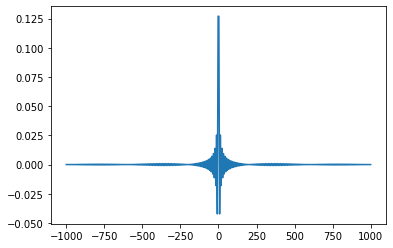

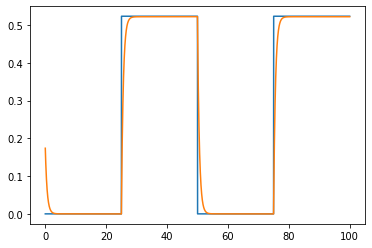

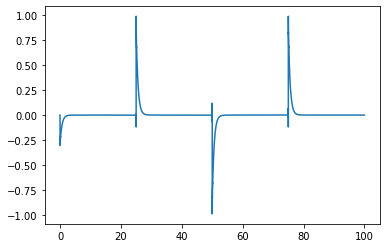

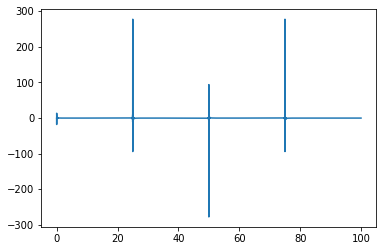

In [30]:

tn = 0.002
pps = int(np.trunc(1/tn))
sim_time = 100

trajectory_points_count=pps*sim_time
tpc = trajectory_points_count
time_space = np.linspace(0,sim_time, trajectory_points_count, False)


period = 50
amp = 30
rect_sig = lambda t: 0 if t-(t//period)*period < period*0.5 else amp

rect = np.vectorize(rect_sig)(time_space)
psi_reference = np.zeros(trajectory_points_count)
psi_reference_dot = np.zeros(trajectory_points_count)
psi_reference_dot_dot = np.zeros(trajectory_points_count)
psi_dot_last = 0
psi_last = 10
psi_now = 0

k = 1
T = 0.6

# przepuszczenie funkcji prostokątnej przez obiekt inercyjny, aby nadać mu krągłości xd,
# ale wsumie to jest to chyba potrzebne żeby różniczka z niego wykorzystywane w różniczce uchybu nie była zjebana

dlugosc = 1000
spoints = 400
sinc_space = np.linspace(-dlugosc, dlugosc, spoints)
sinc = np.sinc(sinc_space)

plt.plot(sinc_space, sinc)
plt.show()

for i in range(trajectory_points_count):
    x_now = rect[i]
    psi_now = (k*x_now - psi_last)/T * tn + psi_last
    
    psi_reference[i] = psi_now
    psi_last = psi_now

a = np.ones(spoints//2)*10
b = psi_reference
c = np.ones(spoints//2-1)*amp

d = np.concatenate((a, b, c), axis=None)
ref_sinc = np.convolve(d, sinc, 'valid')* 2*np.pi/360 * 5.0   
# a jeszcze pozamieniam  na radiany
rect = rect * 2*np.pi/360
psi_reference = ref_sinc

psi_dot_last = 0
psi_last = 10

for n in range(trajectory_points_count):

    psi_dot_now = (psi_reference[n] - psi_last)/tn
    psi_reference_dot[n] = psi_dot_now
    psi_reference_dot_dot[n] = (psi_dot_now - psi_dot_last)/tn
    psi_dot_last = psi_dot_now
    
    psi_last = psi_reference[n]

    

plt.plot(time_space, rect)
plt.plot(time_space, psi_reference)
plt.show()

let = 3

a = np.zeros(let+1)
psi_reference_dot = np.concatenate((a,psi_reference_dot[let:-1]))

a = np.zeros(let+1)
psi_reference_dot_dot = np.concatenate((a,psi_reference_dot_dot[let:-1]))

plt.plot(time_space, psi_reference_dot)
plt.show()

plt.plot(time_space, psi_reference_dot_dot)
plt.show()



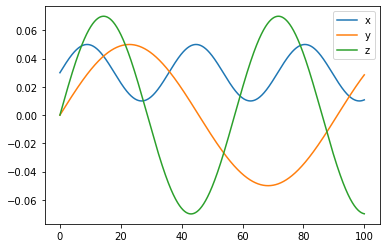

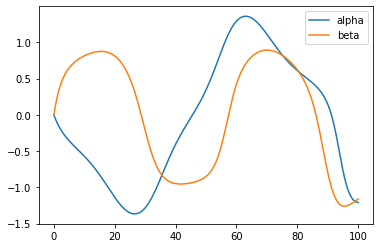

In [31]:
# w artykule nie ma nic o źródle pochodzenia w_x w_z v_x v_y v_z takżę pizgnę sobie je z czapy ignorując
# ich potencjalną dynamikę czy wymuszenie

# spreparowane velocities
f_mult = 0.43
ve_x = np.sin(time_space*np.pi*0.13*f_mult)*0.02 + 0.03
ve_y = np.sin(time_space*np.pi*0.051*f_mult)*0.05
ve_z = np.sin(time_space*np.pi*0.081*f_mult)*0.07
# W metrach na sekundę

plt.plot(time_space, ve_x)
plt.plot(time_space, ve_y)
plt.plot(time_space, ve_z)
plt.legend(['x', 'y', 'z'])
plt.show()

# spreparowane współczynniki alfa i beta
alpha_prep = np.zeros(tpc)
beta_prep = np.zeros(tpc)

for n in range(tpc):
    alpha_prep[n] = alpha_f(ve_x[n], ve_y[n])
    beta_prep[n] = beta_f(ve_x[n], ve_y[n], ve_z[n])
    
plt.plot(time_space, alpha_prep)
plt.plot(time_space, beta_prep)
plt.legend(['alpha', 'beta'])
plt.show()


    

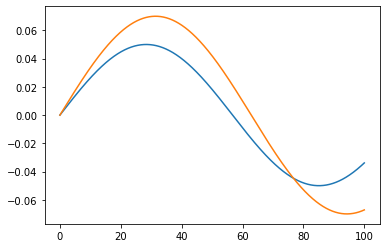

In [32]:
# spreparowane angular velocities
ave_x = np.sin(time_space*np.pi*0.041*f_mult)*0.05
ave_z = np.sin(time_space*np.pi*0.037*f_mult)*0.07
# w radianach na sekundę

plt.plot(time_space, ave_x)
plt.plot(time_space, ave_z)
plt.show()

In [33]:
# tu będzei musiała się pojawić jednoczesna symulacja s, s_prim, e_prim, estymat, w_y oraz na wszelki wypadek macierzy rotacji 
# la grande simulatione xD
k= 0.02

k_1 = 60
k_2 = 6
k_3 = 60

lambda_sim = 1
tau = 20

h_estim_sim_last = np.matrix([-1,2]).T
b_estim_sim_last = 0
p_estim_sim_last = 0.5

psi_sim_last = 0.1745 # 10 stopni w radianach
teta_sim_last = 0 #nie ma danych
phi_sim_last = 0 #nie ma danych

omega_y_sim_last = 0.0523 # 3 st/rad w radianach

a_sim_last = np.matrix([psi_sim_last, teta_sim_last, phi_sim_last]).T
s_sim_last = 0

h1_estim_wykres = np.zeros(tpc)
h2_estim_wykres = np.zeros(tpc)
b_estim_wykres = np.zeros(tpc)
p_estim_wykres = np.zeros(tpc)

psi_wykres = np.zeros(tpc)
omega_y_wykres = np.zeros(tpc)
tau_wykres = np.zeros(tpc)
s_wykres = np.zeros(tpc)

c_3 = 1.8207

mysing = lambda s: np.tanh(s)

for n in range(tpc):
    psi_male = np.matrix([omega_y_sim_last, beta_prep[n]]).T

#     print(psi_sim_last)
    s_sim = omega_y_sim_last - psi_reference_dot[n] + lambda_sim*(psi_sim_last - psi_reference[n])
    
    L_sim1 = -tau*s_sim
    L_sim2 = - k*mysing(s_sim)
    L_sim3 = - h_estim_sim_last.T*psi_male
    L_sim4 = - p_estim_sim_last*mysing(s_sim)
    L_sim5 = psi_reference_dot_dot[n]
    L_sim6 = - lambda_sim*(omega_y_sim_last - psi_reference_dot[n])
    
    
    L_sim = L_sim1 + L_sim2 + L_sim3 + L_sim4 + L_sim5 + L_sim6
        
    tmp = omega_y_sim_last
    ave_sim = np.matrix([ave_x[n], tmp, ave_z[n]]).T
    
    h_estim_sim_now = (k_1 * psi_male * s_sim) * tn + h_estim_sim_last
    b_estim_sim_now = (-k_2 * L_sim * s_sim) * tn + b_estim_sim_last
    p_estim_sim_now = (k_3 * np.abs(s_sim)) * tn + p_estim_sim_last
    

#     print(a_sim_last)
#     print(a_sim_last[0])
#     print(a_sim_last[0].item())
    a_sim1 = R_f(a_sim_last[0].item(), a_sim_last[1].item(), a_sim_last[2].item())
    a_sim_now = a_sim1 * ave_sim * tn + a_sim_last
    
    
    tau_ster = b_estim_sim_last * L_sim
    
# Dynamika nie uwzględnia f ponieważnie ma dokładnej informacji o niej
# informację o tym należałoby wyciągnąć z dynamiki nie uporszczonej
# a najlepiej zapytać promotora o co b
    omega_y_sim_now = (h_estim_sim_last.T*psi_male + c_3*tau_ster + dis_f(time_space[n])) * tn + omega_y_sim_last
    psi_sim_now = a_sim_now[0].item()
    
#     value check
#     print('nowalinia--------------')
#     print('s_sim', s_sim)
#     print('L_sim', L_sim1,  L_sim2,  L_sim3,  L_sim4,  L_sim5,  L_sim6)
#     print('h estim', h_estim_sim_now)
#     print('b estim', b_estim_sim_now)
#     print('p estim', p_estim_sim_now)
    
#     print(b_estim_sim_now)
    h1_estim_wykres[n] = h_estim_sim_now[0].item()
    h2_estim_wykres[n] = h_estim_sim_now[1].item()
    b_estim_wykres[n] = b_estim_sim_now.item()
    p_estim_wykres[n] = p_estim_sim_now.item()
    
    h_estim_sim_last = h_estim_sim_now
    b_estim_sim_last = b_estim_sim_now
    p_estim_sim_last = p_estim_sim_now
    
    
    tau_wykres[n] = tau_ster.item()
    omega_y_wykres[n] = omega_y_sim_now[0].item()
    psi_wykres[n] = psi_sim_now
    s_wykres[n] = s_sim
    
    omega_y_sim_last = omega_y_sim_now.item()
    psi_sim_last = psi_sim_now
    a_sim_last = a_sim_now
    if n%(tpc//10) == 0:
        print(n)
    

    

0
5000
10000


C:\Users\Wojciech\anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: invalid value encountered in cos
<string>:2: RuntimeWarning: invalid value encountered in sin


15000
20000
25000
30000
35000
40000
45000


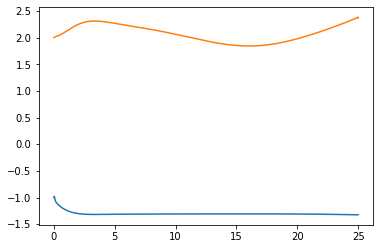

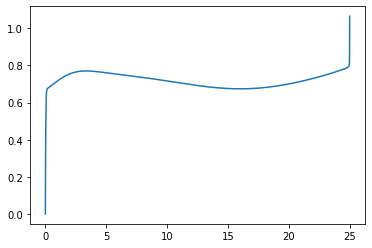

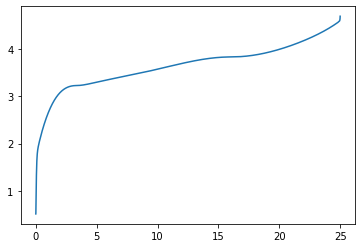

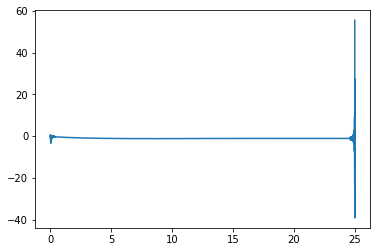

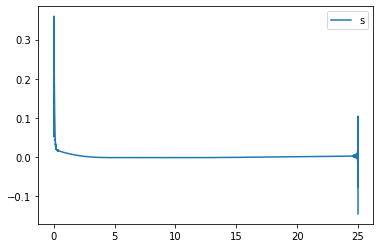

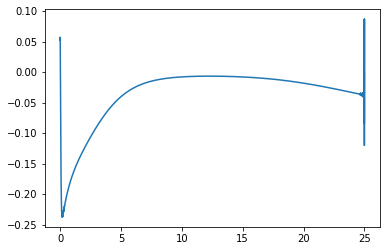

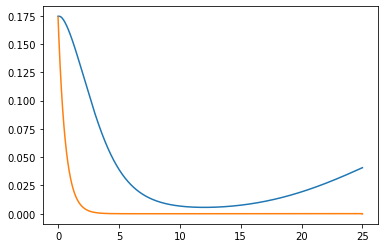

In [34]:
last = (tpc//4)
time_space1 = time_space[0:last]
h1_estim_wykres1 = h1_estim_wykres[0:last]
h2_estim_wykres1 = h2_estim_wykres[0:last]
b_estim_wykres1 = b_estim_wykres[0:last]
p_estim_wykres1 = p_estim_wykres[0:last]
tau_wykres1 = tau_wykres[0:last]
omega_y_wykres1 = omega_y_wykres[0:last]
psi_wykres1 = psi_wykres[0:last]
psi_ref1 = psi_reference[0:last]
s_wykres1 = s_wykres[0:last]

plt.plot(time_space1, h1_estim_wykres1, time_space1, h2_estim_wykres1)
plt.show()

plt.plot(time_space1, b_estim_wykres1)
plt.show()

plt.plot(time_space1, p_estim_wykres1)
plt.show()

plt.plot(time_space1, tau_wykres1)
plt.show()

plt.plot(time_space1, s_wykres1)
plt.legend(['s'])
plt.show()


plt.plot(time_space1, omega_y_wykres1)
plt.show()

plt.plot(time_space1, psi_wykres1,time_space1, psi_ref1)
plt.show()